In [1]:
setwd("C:/Users/User/OneDrive/Documentos")
source("Meus Arquivos/Códigos/Funções.R")

In [2]:
options(warn = -1)
pacotes <- c("tidyquant", "tidyverse", "rugarch",
             "PerformanceAnalytics", "rmgarch", "bizdays")
for(i in pacotes){
  suppressPackageStartupMessages(library(i, character.only = T))
}

In [21]:
acoes <- c("TRPL4.SA","ITSA4.SA","ABEV3.SA","B3SA3.SA","MGLU3.SA","ENAT3.SA","DIRR3.SA","FLRY3.SA","AGRO3.SA")
benchmark <- "^BVSP"
data_inicio <- "2013-01-01"
#Coletando os preços das ações
returns <- tq_get(acoes, from = data_inicio) %>%
  mutate(adjusted = abs(adjusted)) %>%
  group_by(symbol) %>%
  tq_transmute(select = adjusted, mutate_fun = dailyReturn)
bench <- tq_get(benchmark, from = data_inicio) %>%
  mutate(adjusted = abs(adjusted)) %>%
  tq_transmute(select = adjusted, mutate_fun = dailyReturn)

In [22]:
pesos <- c(0.1879,0.1557,0.1447,0.1356,0.1091,0.0813,0.0632,0.0623,0.0602)
pesos <- pesos/sum(pesos)
pesos <- data.frame(symbol = acoes, w = pesos)
port_h <- returns %>%
  tq_portfolio(symbol,
               returns_col = daily.returns,
               weights = pesos,
               col_rename ="Hold")
port_w <- returns %>%
  tq_portfolio(symbol,
               returns_col = daily.returns,
               weights = pesos,
               col_rename = "Semanal",
               rebalance_on = "weeks")
port_m <- returns %>%
  tq_portfolio(symbol, 
               returns_col = daily.returns,
               weights = pesos,
               col_rename = "Mensal",
               rebalance_on = "months")
port_y <- returns %>%
  tq_portfolio(symbol,
               returns_col = daily.returns,
               weights = pesos,
               col_rename = "Anual",
               rebalance_on = "years")
port_tot <- left_join(port_h, port_w, "date") %>%
  left_join(port_m, "date") %>%
  left_join(port_y, "date") %>%
  gather(key = "Rebalanceamento", value = "Retornos", -date)

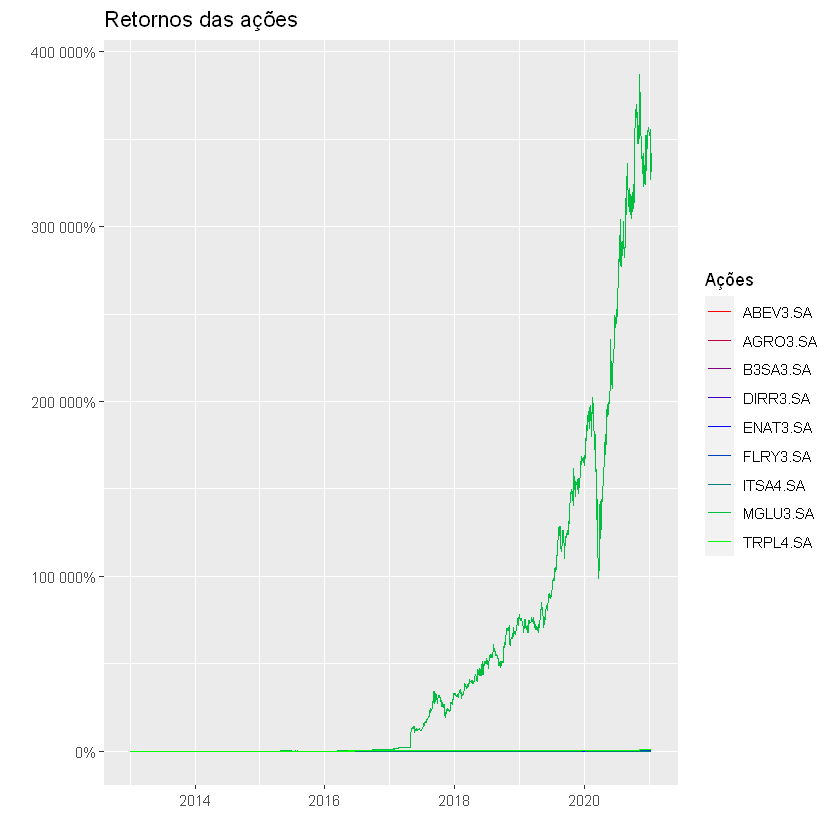

In [23]:
cores <- colorRampPalette(c("red","blue","green"))(length(acoes))
returns %>%
  group_by(symbol) %>%
  mutate(daily.returns = cumprod(1+daily.returns)-1) %>%
  ungroup() %>%
  ggplot(aes(x = date, y = daily.returns, col = symbol))+
  geom_line()+
  labs(x = "", y = "", title = "Retornos das ações")+
  scale_y_continuous(labels = scales::percent)+
  scale_color_manual("Ações", values = cores)

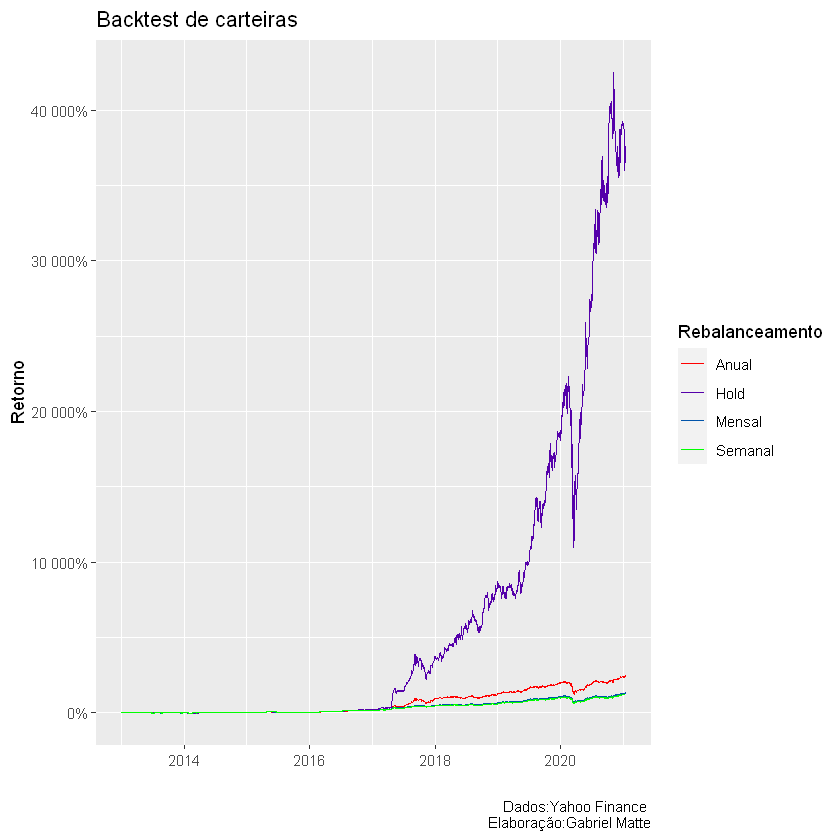

In [24]:
cores1 <- colorRampPalette(c("red","blue","green"))(4)
port_tot %>%
  group_by(Rebalanceamento) %>%
  mutate(Retornos = cumprod(Retornos+1)-1) %>%
  ungroup() %>%
  ggplot(aes(x = date, y = Retornos, col = Rebalanceamento))+
  geom_line()+
  scale_y_continuous(labels = scales::percent)+
  labs(x = "", y = "Retorno", 
       title = "Backtest de carteiras", 
       caption = "Dados:Yahoo Finance \n Elaboração:Gabriel Matte")+
  scale_color_manual("Rebalanceamento", values = cores1)

In [25]:
port_tot %>%
  group_by(Rebalanceamento) %>%
  mutate(Retornos = cumprod(Retornos+1)-1) %>%
  filter(date == xts::last(date))

date,Rebalanceamento,Retornos
<date>,<chr>,<dbl>
2021-01-15,Hold,370.70431
2021-01-15,Semanal,12.19415
2021-01-15,Mensal,13.01492
2021-01-15,Anual,24.21904


In [26]:
#Sharpe
tx_l <- 0.0025
anual <- T
if(isTRUE(anual)){
  tx_l <- ((1+tx_l)^(1/252))-1
}
sharpe <- port_tot %>%
  group_by(Rebalanceamento) %>%
  tq_performance(Ra = Retornos, performance_fun = SharpeRatio, Rf = tx_l)
sharpe[,-1] <- sharpe[,-1]*sqrt(252)
sharpe

VaR calculation produces unreliable result (inverse risk) for column: 1 : -0.146391547029434

ES calculation produces unreliable result (inverse risk) for column: 1 : -0.00182804300003985

VaR calculation produces unreliable result (inverse risk) for column: 1 : -2.05303508158046

ES calculation produces unreliable result (inverse risk) for column: 1 : -0.00377131534951076

VaR calculation produces unreliable result (inverse risk) for column: 1 : -0.064404960890032

VaR calculation produces unreliable result (inverse risk) for column: 1 : -0.0307517733479071



Rebalanceamento,"ESSharpe(Rf=0%,p=95%)","StdDevSharpe(Rf=0%,p=95%)","VaRSharpe(Rf=0%,p=95%)"
<chr>,<dbl>,<dbl>,<dbl>
Hold,NA,1.167563,NA
Semanal,0.13131848,1.325999,NA
Mensal,0.07997133,1.314839,NA
Anual,NA,1.343827,NA


In [27]:
#Kelly e Omega
port_tot %>%
  group_by(Rebalanceamento) %>%
  tq_performance(Ra = Retornos, performance_fun = Omega, L = tx_l)
port_tot %>%
  group_by(Rebalanceamento) %>%
  tq_performance(Ra = Retornos, performance_fun = KellyRatio, Rf = tx_l)

Rebalanceamento,Omega(L=0%)
<chr>,<dbl>
Hold,1.510780
Semanal,1.312777
Mensal,1.320833
Anual,1.356210


Rebalanceamento,KellyRatio
<chr>,<dbl>
Hold,0.7190842
Semanal,2.4492506
Mensal,2.3459267
Anual,1.9680151


In [28]:
#CAPM
tot <- left_join(port_tot,bench,"date") %>%
  rename(Ra = Retornos, Rb = daily.returns)
capm <- tot %>%
  group_by(Rebalanceamento) %>%
  tq_performance(Ra, Rb, performance_fun = table.CAPM, digits = 10)
capm <- capm %>%
  gather(key = "Indicadores", value = "value", -Rebalanceamento) %>%
  spread(key = Rebalanceamento, value = value)
capm

Indicadores,Anual,Hold,Mensal,Semanal
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ActivePremium,0.419371487,1.032224746,0.31118119,0.300517197
Alpha,0.001476464,0.003334043,0.00112556,0.001086253
AnnualizedAlpha,0.450335018,1.313545616,0.32774445,0.314671842
Beta,0.772094012,0.966445646,0.75282953,0.755709509
Beta-,0.886359706,1.252317983,0.84320310,0.841015011
Beta+,0.684203983,0.999538713,0.68578415,0.691977487
Correlation,0.592651978,0.311975049,0.70401672,0.731626186
Correlationp-value,0.000000000,0.000000000,0.00000000,0.000000000
InformationRatio,1.487266598,1.337790503,1.48146370,1.532232890


In [29]:
#VaR
metodos <- c("modified","gaussian","historical")
lista <- replicate(length(metodos),list())
for(i in 1:length(metodos)){
  lista[[i]] <- port_tot %>%
    group_by(Rebalanceamento) %>%
    tq_performance(Ra = Retornos, performance_fun = VaR, method = metodos[i])
  names(lista)[[i]] <- metodos[i]
}
lista

VaR calculation produces unreliable result (inverse risk) for column: 1 : -0.146391547029434

VaR calculation produces unreliable result (inverse risk) for column: 1 : -2.05303508158046

VaR calculation produces unreliable result (inverse risk) for column: 1 : -0.064404960890032

VaR calculation produces unreliable result (inverse risk) for column: 1 : -0.0307517733479071



Rebalanceamento,VaR
<chr>,<dbl>
Hold,NA
Semanal,NA
Mensal,NA
Anual,NA
Rebalanceamento,VaR
<chr>,<dbl>
Hold,-0.08032726
Semanal,-0.02660702
Mensal,-0.02755785


In [12]:
#Carteira escolhida
var_h <- port_y$Anual
dates <- port_y$date
var_h <- xts(var_h,dates)
var_ibov <- xts(bench$daily.returns,bench$date)

In [ ]:
arch <- suppressMessages(find_best_arch_model(na.omit(var_h),
                             dist_to_use = c("norm","snorm"), min_GARCH = 1, min_ARCH = 1,
                         type_models = c("sGARCH","eGARCH"),max_lag_AR = 1))

In [32]:
ugspec <- arch$ugspec_b
ugfit <- ugarchfit(ugspec, na.omit(var_h))

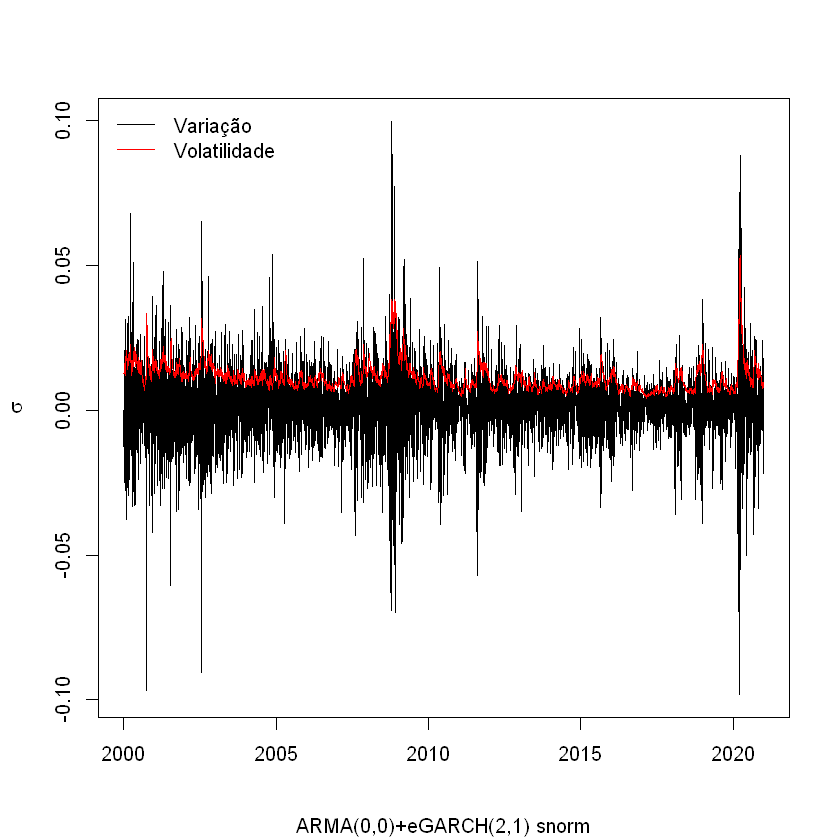

In [33]:
plot(dates, as.numeric(var_h), type = "l",
     sub = arch$best_bic$model_name, xlab = "",ylab = expression(sigma, mu))
lines(dates,ugfit@fit$sigma, col = "red")
legend("topleft", legend = c("Variação", "Volatilidade"),
       lty = c(1,1), col = c("black","red"),
       bty = "n")

In [34]:
#VaR test
alpha <- 0.05
VaRTest(alpha, actual = var_h, VaR = quantile(ugfit, alpha))

$expected.exceed
[1] 264

$actual.exceed
[1] 248

$uc.H0
[1] "Correct Exceedances"

$uc.LRstat
[1] NaN

$uc.critical
[1] 3.841459

$uc.LRp
[1] NaN

$uc.Decision
[1] NA

$cc.H0
[1] "Correct Exceedances & Independent"

$cc.LRstat
[1] NaN

$cc.critical
[1] 5.991465

$cc.LRp
[1] NaN

$cc.Decision
[1] NA

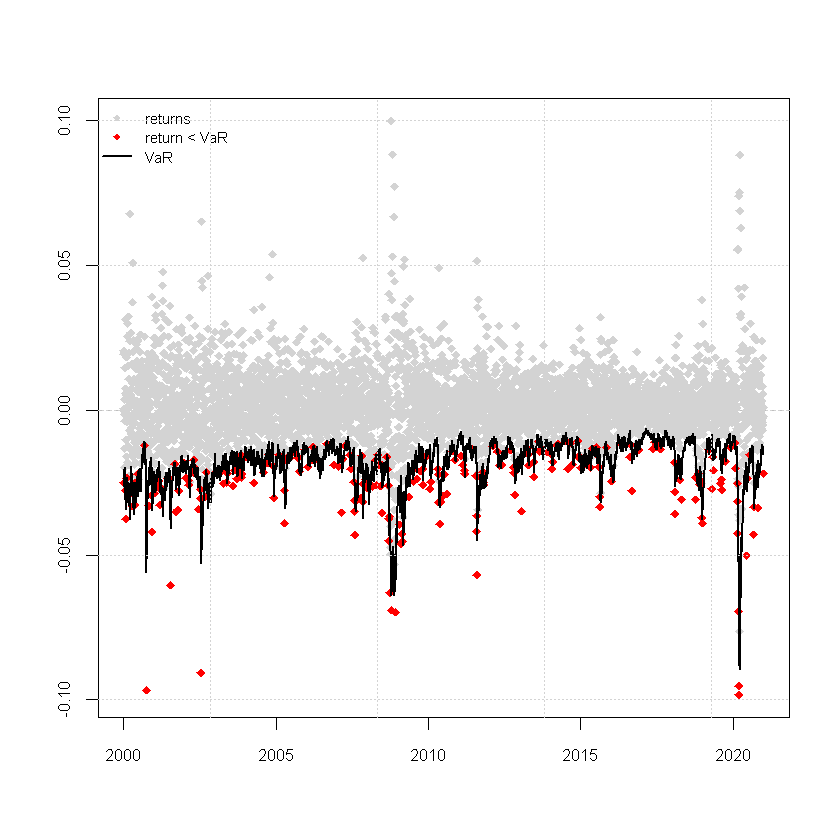

In [35]:
#VaR plot
VaRplot(alpha = alpha,actual = var_h, VaR = quantile(ugfit, alpha))

In [36]:
dias <- 252
simulacoes <- 7000

In [37]:
ugsim <- ugarchsim(ugfit, n.sim = simulacoes, m.sim = dias)
sim <- t(ugsim@simulation$seriesSim)
sim <- sim+1
sim <- apply(sim,2,cumprod)

In [38]:
data_sim <- bizdays::bizseq(Sys.Date()+1, Sys.Date()+365*10, "Brazil/ANBIMA")[1:dias]

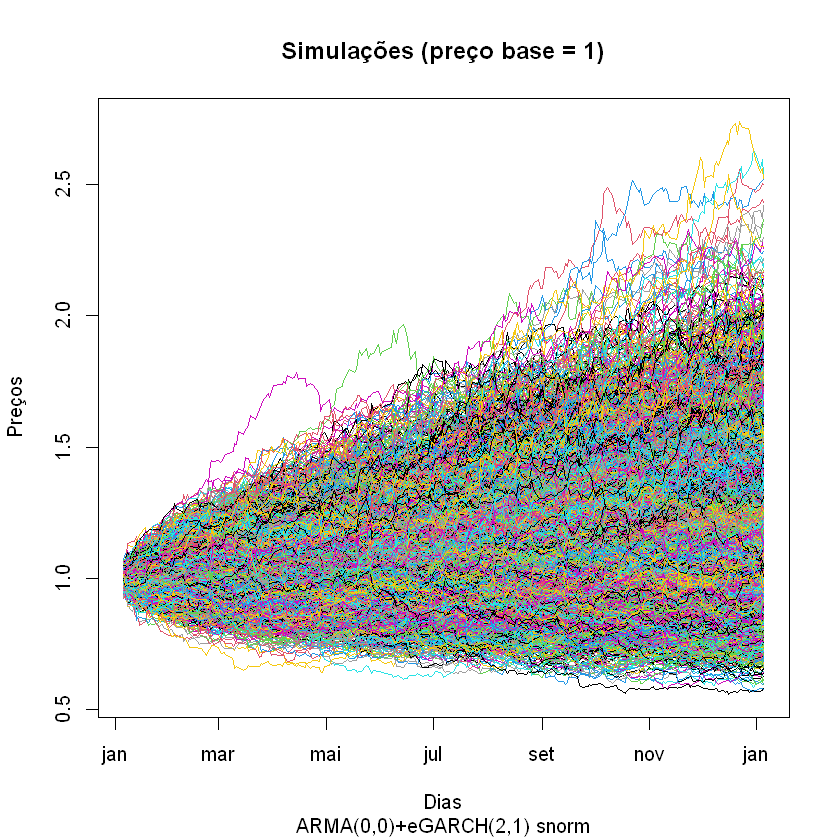

In [39]:
matplot(data_sim,sim, type = "l", lty = 1, col = 1:ncol(sim),
        xlab = "Dias", ylab = "Preços",
        main = "Simulações (preço base = 1)",
        sub = arch$best_bic$model_name)

`summarise()` ungrouping output (override with `.groups` argument)



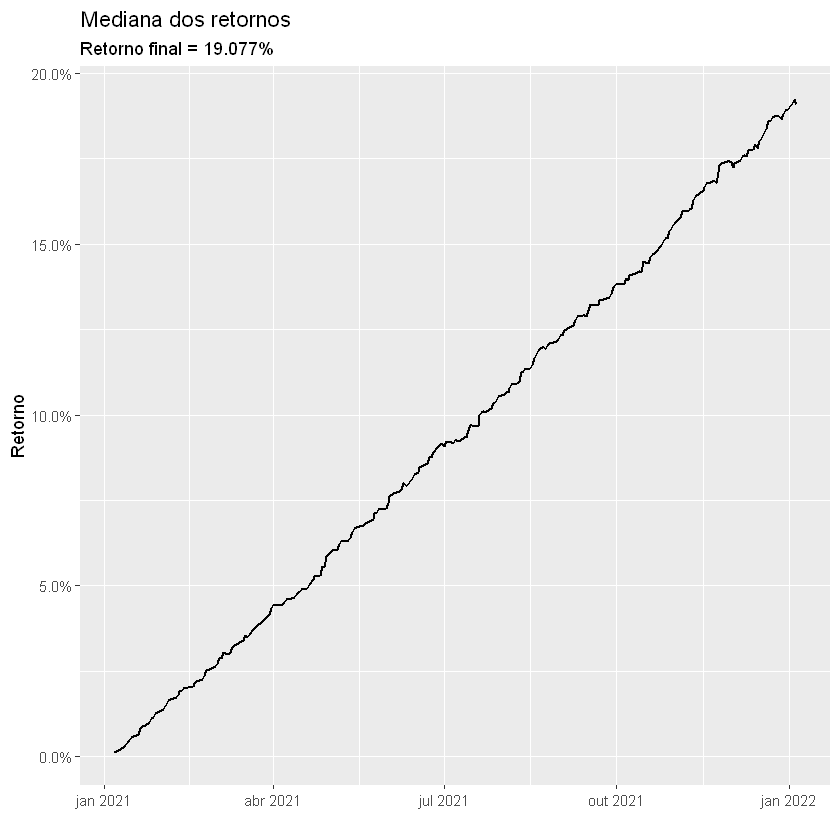

In [40]:
mediana <- sim %>%
  as.data.frame() %>%
  mutate(periodo = data_sim) %>%
  gather(key = "key", value = "value", -periodo) %>%
  group_by(periodo) %>%
  summarise(mediana = median(value)-1)
ggplot(mediana, aes(x = periodo, y = mediana))+
  geom_line(size = 0.7)+
  scale_y_continuous(labels = scales::percent)+
  labs(x = "", y = "Retorno", title = "Mediana dos retornos",
       subtitle = paste0("Retorno final = ", round(xts::last(mediana$mediana)*100,3),"%"))

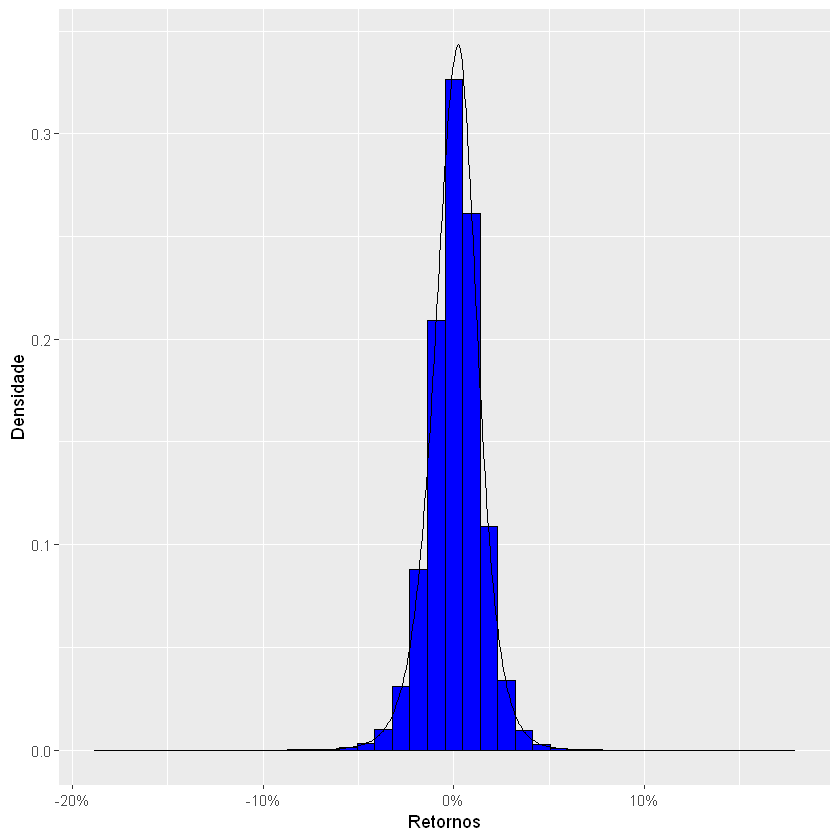

In [41]:
dif <- diff(sim)/sim[2:nrow(sim)-1,] %>% as.data.frame()
v <- dif %>%
  gather()
v %>%
  ggplot(aes(x = value, y = after_stat(density)/100))+
  geom_histogram(bins = 40, col = "black", fill = "blue")+
  geom_density()+
  labs(x = "Retornos", y = "Densidade")+
  scale_x_continuous(labels = scales::percent)

In [42]:
#VaR da simulação
var <- round(quantile(v$value, prob = c(0.05,0.01))*100,3)
print(var)

    5%     1% 
-2.162 -3.518 


In [43]:
#VaR Histórico
round(quantile(var_h, prob = c(0.05,0.01), na.rm = T)*100,3) %>% print

    5%     1% 
-1.891 -3.425 


In [44]:
mínimo <- round((min(sim)-1)*100,3)
máximo <- round((max(sim)-1)*100,3)
names(mínimo) <- "Retorno Mínimo"
names(máximo) <- "Retorno Máximo"
paste0("Retorno Mínimo = ",mínimo,"%")
paste0("Retorno Máximo = ", máximo,"%")

[1] "Retorno Mínimo = -44.387%"

[1] "Retorno Máximo = 174.141%"

`summarise()` ungrouping output (override with `.groups` argument)



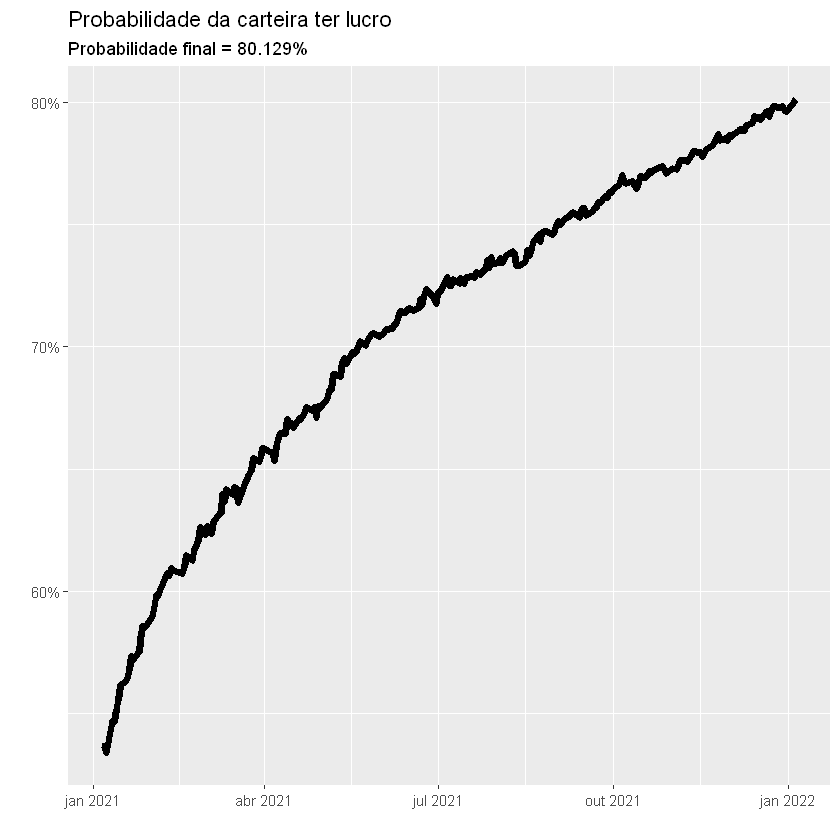

In [45]:
prob <- sim %>%
  as.data.frame() %>%
  mutate(periodo = data_sim) %>%
  gather(key = "key", value = "value",-periodo) %>%
  group_by(periodo) %>%
  summarise(prob = mean(value > 1))
prob %>%
  ggplot(aes(x = periodo, y = prob))+
  geom_line(size = 2)+
  labs(x = "", y = "", title = "Probabilidade da carteira ter lucro",
      subtitle = paste0("Probabilidade final = ",round(xts::last(prob$prob)*100,3), "%"))+
  scale_y_continuous(labels = scales::percent)

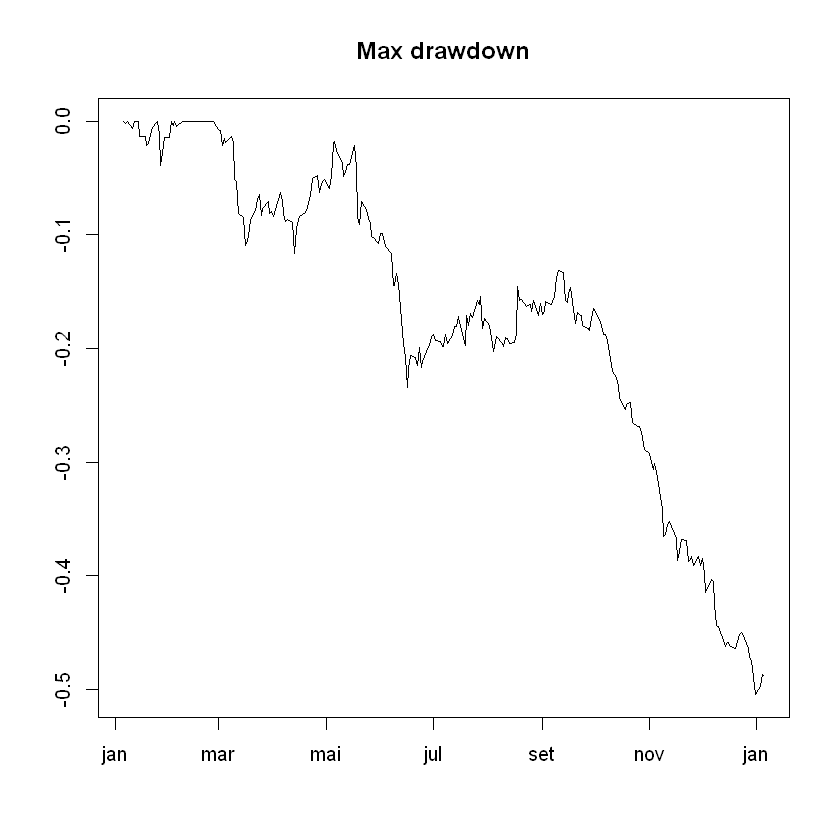

In [46]:
#Max Drawdrown
maxs <- apply(sim,2,cummax)
draw <- matrix(nrow = nrow(sim), ncol = ncol(sim))
for(i in 1:ncol(draw)){
  draw[,i] <- sim[,i]/maxs[,i]-1
}
mins <- apply(draw,2,min)
plot(data_sim,draw[,which.min(mins)], type = "l", xlab = "", ylab = "", main = "Max drawdown")

In [47]:
#Mean Drawdown
paste0("Mean Drawdown = ",round(mean(draw)*100, 3),"%")

[1] "Mean Drawdown = -6.471%"

In [48]:
med <- (coef(ugfit)["mu"]*252)
sd_c <- xts::last(sigma(ugfit)*sqrt(252))
tx_livre <- 0.02
data1 <- data.frame(Retorno = med, Risco = sd_c, Sharpe = (med-tx_livre)/sd_c)

In [49]:
data1

,Retorno,Risco,Sharpe
,<dbl>,<dbl>,<dbl>
mu,0.2014479,0.1401114,1.295026


In [34]:
var_tot <- cbind(var_h,var_ibov) %>% na.omit

In [35]:
arch1 <- suppressMessages(apply(var_tot,2,find_best_arch_model,
                               dist_to_use = c("snorm","std"), min_GARCH = 1, min_ARCH = 1,
                               type_model = c("sGARCH","eGARCH"), max_lag_AR = 1))

In [36]:
multi <- replicate(2,list())
for(i in 1:length(multi)){
  multi[[i]] <- arch1[[i]]$ugspec_b
}

In [37]:
multspec <- multispec(multi)
multf <- multifit(multispec = multspec, data = var_tot)
best <- suppressMessages(find_best_dcc_model(var_tot,
                                             uspec = multspec,
                                             dist_to_use = c("mvnorm","mvt")))
spec1 <- best$dccspec_b
fit1 <- dccfit(spec1, data = var_tot, fit = multf, fit.control = list(eval.se = T))

In [38]:
coefs <- numeric(length = ncol(var_tot))
for(i in 1:length(coefs)){
  coefs[i] <- multf@fit[[i]]@fit$coef["mu"]*252
}
cov1 <- rcov(fit1)
cova <- cov1[1,2,]
sd <- matrix(0, nrow = nrow(var_tot), ncol = ncol(var_tot))
for(i in 1:ncol(var_tot)){
  sd[,i] <- multf@fit[[i]]@fit$sigma
}

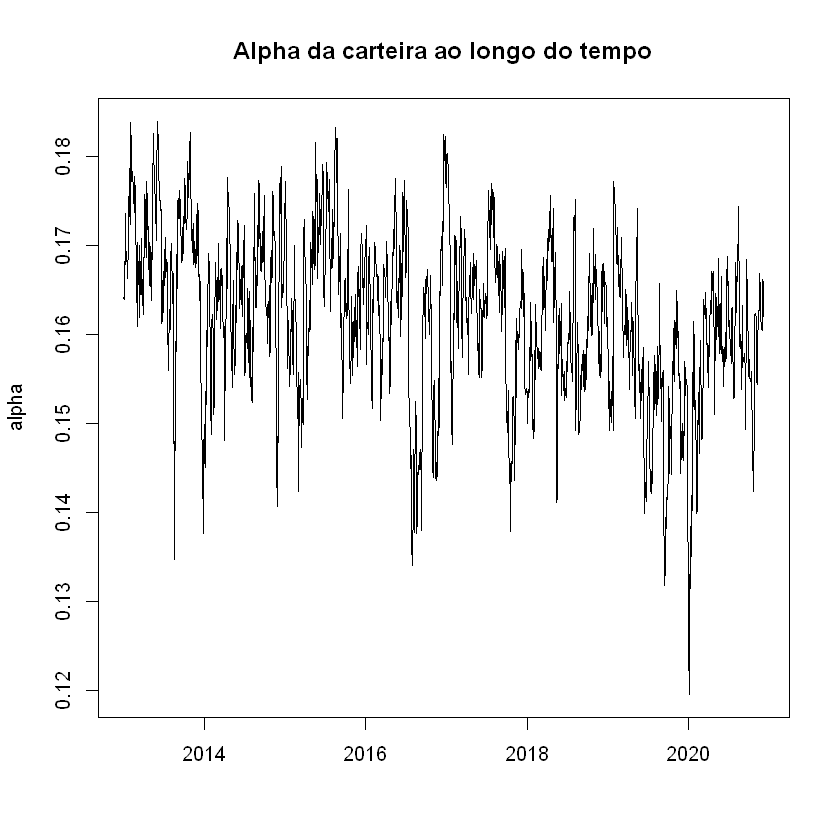

In [39]:
beta <- cova/sd[,2]^2
alpha <- (coefs[1]-tx_livre)-beta*(coefs[2]-tx_livre)
plot(na.omit(bench$date),alpha, type = "l", main = "Alpha da carteira ao longo do tempo", xlab = "")

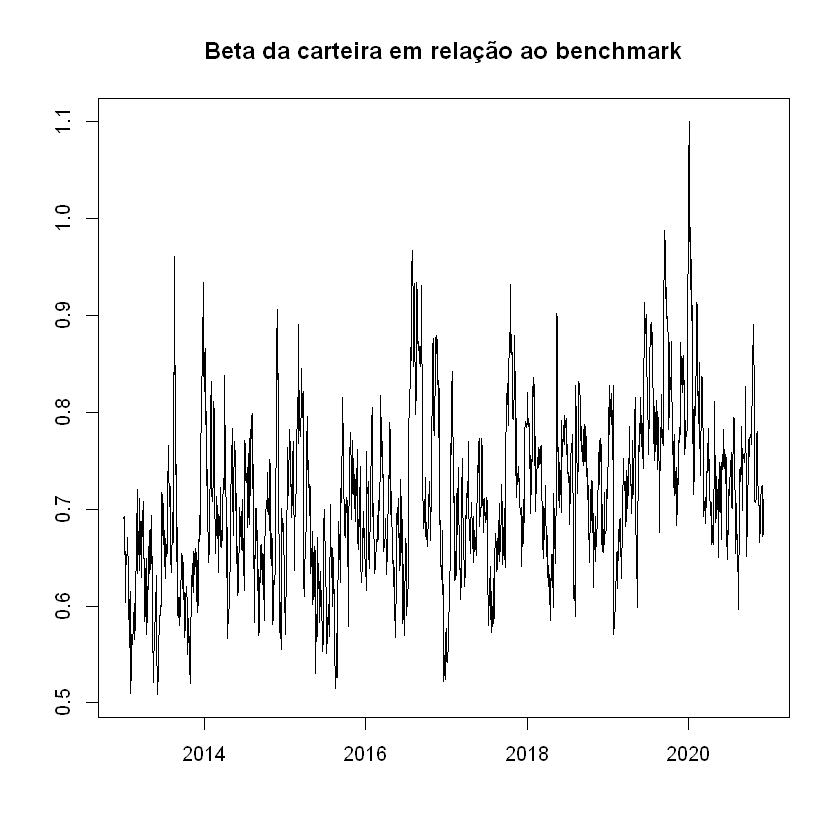

In [40]:
plot(na.omit(bench$date),beta,
     type = "l",
     main = "Beta da carteira em relação ao benchmark",
     xlab = "",
     ylab = "")

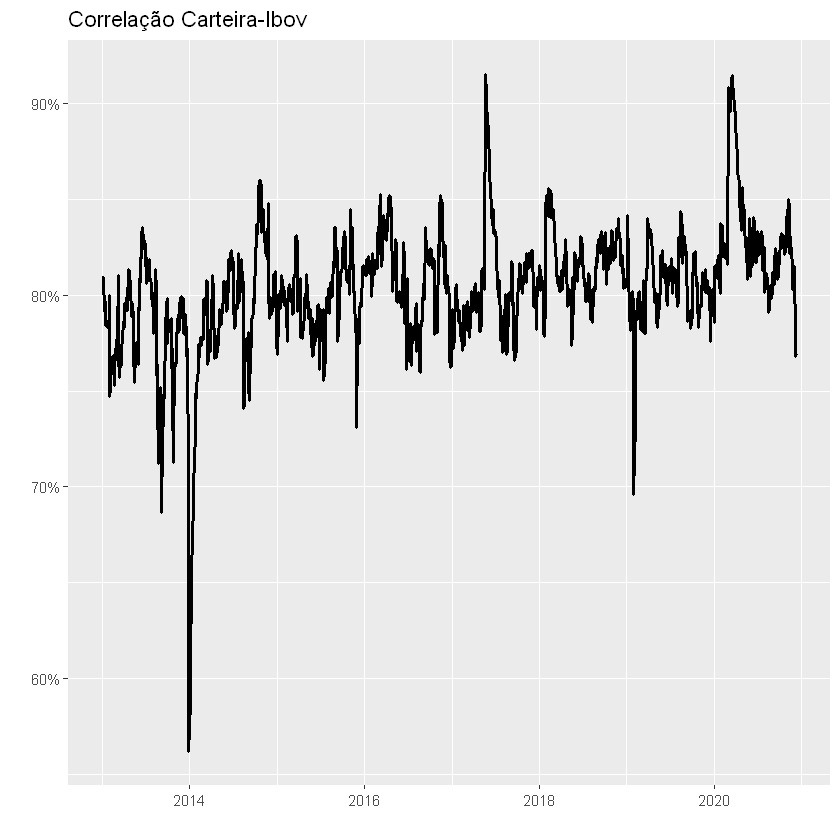

In [41]:
corr <- rcor(fit1)[1,2,]
corre <- data.frame(date = na.omit(bench$date), cor = corr)
ggplot(corre, aes(x = date, y = cor))+
    geom_line(size = 1)+
    labs(x = "", y = "", title = "Correlação Carteira-Ibov")+
    scale_y_continuous(labels = scales::percent)